# Effect of using thresholds with softmax

This notebook shows the effect of choosing thresholds for the softmax layer in classification problems.

The usual approach is to choose the maximum of the predicted probabilities:

... code here <<<<<<<<

However, this gloses over the fact that sometimes two or more classes have very close predicted probabilities.

Using the MNIST dataset, we will investigate the effect of settings thresholds to make predictions, instead of simply the maximum probability.

Sources:

- [Tensorflow MNIST example](https://www.tensorflow.org/datasets/keras_example)
- [Keras MNIST example](https://keras.io/examples/vision/mnist_convnet/)
- [Multi-label vs. Multi-class Classification: Sigmoid vs. Softmax](https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)
- [Interpreting logits: sigmoid vs softmax](https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax.html)

In [39]:
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

To increase reproducibility (but still not guaranteed to get exactly the same results because of parallelism and GPU usages).

References:

- [Stackoverflow](https://stackoverflow.com/a/53760258)
- Tensorflow `set_seed`](https://www.tensorflow.org/api_docs/python/tf/random/set_seed)

In [2]:
SEED=1234
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load MNIST and create the training/test pipelines

The code in this section is from the [TensorFlow MNIST example](https://www.tensorflow.org/datasets/keras_example).

Load MNIST.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Build training pipeline.

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

Build test pipeline.

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Train a model

The model is a simple network of dense layers that can achieve about 98% accuracy in less than one minute of training.

This accuracy is enough for the experiments. We are interested in the effect of using different thresholds with softmax, not on very high accuracy for the model.

In [6]:
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28)
ACTIVATION='relu'

In [13]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), 
#     activation=ACTIVATION, input_shape=INPUT_SHAPE, padding='same'),
#   tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
#     padding='valid'),
#   tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), 
#     activation=ACTIVATION, padding='valid'),
#   tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2),
#     padding='valid'),
#   tf.keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1),
#     activation=ACTIVATION, padding='valid'),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(84, activation=ACTIVATION),
#   tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
  tf.keras.layers.Dense(512, activation=ACTIVATION),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation=ACTIVATION),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

Use early stopping to get a decent model without investing too much time in training. The main purspose of this notebook is not to get high accuracy. It's to demonstrate the effect of softmax thresholds.

In [14]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True)

model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
    callbacks=[callback]
)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.5445 - sparse_categorical_accuracy: 0.8276 - val_loss: 0.1280 - val_sparse_categorical_accuracy: 0.9589
Epoch 2/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1589 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.0934 - val_sparse_categorical_accuracy: 0.9712
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.0932 - val_sparse_categorical_accuracy: 0.9736
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.9687 - val_loss: 0.0804 - val_sparse_categorical_accuracy: 0.9754
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0930 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.0766 - val_sparse_categorical_accuracy: 0.9771
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0883 - sparse_categorica

## Analyze predictions on the test set

In [9]:
predicted_probability = model.predict(ds_test)
predicted_class = np.argmax(predicted_probability, axis=1)

In [18]:
actual_class_label = list(map(lambda x:x[1], ds_test))

In [19]:
actual_class_label[0]

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([2, 0, 4, 8, 7, 6, 0, 6, 3, 1, 8, 0, 7, 9, 8, 4, 5, 3, 4, 0, 6, 6,
       3, 0, 3, 2, 6, 6, 7, 4, 9, 3, 8, 7, 5, 4, 2, 5, 5, 8, 5, 2, 9, 2,
       4, 2, 7, 0, 5, 1, 0, 7, 9, 9, 9, 6, 8, 8, 5, 6, 9, 9, 5, 4, 2, 6,
       8, 1, 0, 6, 9, 5, 5, 4, 1, 6, 7, 5, 2, 9, 0, 6, 4, 4, 2, 8, 7, 8,
       3, 0, 9, 0, 1, 1, 9, 4, 5, 9, 7, 6, 6, 0, 7, 7, 8, 4, 8, 1, 8, 0,
       9, 8, 2, 1, 0, 3, 9, 7, 0, 4, 9, 6, 8, 9, 5, 4, 3, 3])>

In [12]:
predicted_class[:10]

array([2, 0, 4, 8, 7, 6, 0, 6, 3, 1])

In [40]:
test_labels = np.concatenate([y for _, y in ds_test], axis=0)

In [41]:
test_images = np.concatenate([x for x, _ in ds_test], axis=0)

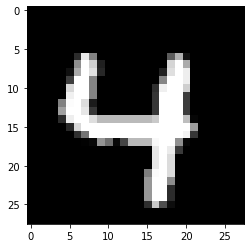

In [44]:
plt.imshow(test_images[2], cmap=plt.get_cmap("gray"))